# Physics 113: Problem Set 3
## Submit notebook to Canvas by May 21, 2023 17:00 PDT

### Question 1: AGN Photometry with Metropolis-Hastings Sampling

In this notebook we will fit a model to X-ray imaging data, using the techniques we discussed earlier in class involving probability distributions and sampling with Metropolis-Hastings.

Provided our discussions following homework 2, I have included some helpful links to describe some Python functionality used throughout this notebook.

Note: you may have to run `pip install corner` in order to help setup the on of the plotting packages used in this assignment

In [1]:
from __future__ import annotations

import corner, copy
import numpy as np 
import scipy.stats as st 
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits


from pathlib import Path
from tqdm.auto import tqdm
from typing import Union, List
from dataclasses import dataclass, field
from astropy.visualization import LogStretch

Distribution = Union[st.rv_continuous, st.rv_discrete]

For this assignment we'll be working with an image produced from X-ray CCD data. There's a fair bit of domain-specific information here, but it's useful stuff to see if you haven't worked with imaging data before (regardless of wavelength). Do note that there is also quite a bit of corner cutting, however; the problems based on these data are meant to get key statistical concepts across, and not to show you how to do a completely rigorous analysis that accounts for all instrumental and systematic effects.

Modern X-ray CCDs are technologically similar to the CCDs used in optical astronomy: when a photon hits a pixel, one or more electrons are promoted into the conduction band and trapped there until being read out. The main practical difference is that X-ray photons are rarer and their energies much higher.

This means that:
* Only for exceptionally bright sources will we ever have $>1$ photon hit a given pixel in an integration, if we read out the CCD every few seconds.
* We do not get 1 electron promoted per photon, as is the case in visible wavelength CCDs. Instead, the number of electrons is roughly proportional to the photon's energy, which means that these imaging devices are actually imaging spectrometers.
* When we say "counts" in this context, we mean "pixel activation events" rather than number of electrons trapped, so that (as in optical astronomy) we're referring to the number of photons detected (or other events that look like photons to the detector).

You probably know that, in python, array indices start from 0. We could choose to work with $x$ and $y$ coordinates that are simply these indices. However, conventionally, astronomical image coordinates are indexed from 1; for example, if we had used the tool `ds9` to define a region of interest in this image, and saved it in "image" coordinates (as opposed to celestial coordinates), the bottom-left pixel in the image would be $(1,1)$. To avoid confusion, we might want to follow this convention.

Similar to last week, we will be taking an [object-oriented programming (OOP) approach](https://youtu.be/txRTzljmV0Q) This data will be managed with the `XRayCCD` [dataclass](https://www.youtube.com/watch?v=CvQ7e6yUtnw) seen below. This class will assist in managing the image and exposure map data, in addition to holding coordinate information in the `mesh` attribute. This class also provides functionality for displaying this data and setting up a "sub-image" for local analysis (sometimes referred to as a postage stamp).

In [2]:
@dataclass
class XRayCCD:
    image: np.ndarray
    exposure_map: np.ndarray
    image_header: pyfits.header.Header
    exposure_map_header: pyfits.header.Header
    mesh: np.ndarray = field(init=False)

    coordinate_offsets: tuple[int, int] = field(default=(1,1))

    def __post_init__(self) -> None:
        x_shift, y_shift = self.coordinate_offsets
        self.mesh = np.meshgrid(
            np.arange(x_shift, self.image.shape[0] + x_shift), 
            np.arange(y_shift, self.image.shape[1] + y_shift)
        )

    @classmethod
    def from_fits(cls, image_path: Path, exp_map_path: Path) -> XRayCCD:
        image_fits = pyfits.open(image_path)
        exposure_map_fits = pyfits.open(exp_map_path)
        image_header = image_fits[0].header
        exposure_map_header = exposure_map_fits[0].header
        print("Image Information")
        image_fits.info()
        print("\nExposure Map Information") 
        exposure_map_fits.info()
        return cls(
            image_fits[0].data, exposure_map_fits[0].data,
            image_header, exposure_map_header
        )
    
    # Return Cropped Version of CCD Image
    def make_postage_stamp(self, width: int, x0: int, y0: int) -> XRayCCD:
        half_width = width // 2  # width of the stamp on either side of the center
        
        # Calculate the bounds of the stamp
        left = max(0, x0 - half_width)
        right = min(self.image.shape[1], x0 + half_width)
        bottom = max(0, y0 - half_width)
        top = min(self.image.shape[0], y0 + half_width)
        
        # Create and return the new XRayCCD object
        return XRayCCD(
            self.image[bottom:top, left:right], 
            self.exposure_map[bottom:top, left:right],
            coordinate_offsets=(left, bottom),
            image_header=self.image_header,
            exposure_map_header=self.exposure_map_header
        )

    @property
    def coordinate_bounds(self) -> tuple[int, int, int, int]:
        return (
            np.min(self.mesh[0]), np.max(self.mesh[0]), 
            np.min(self.mesh[1]), np.max(self.mesh[1])
        )
    
    def pixel_distances_map(self, i: int, j: int, display: bool=False) -> np.ndarray:
        x, y = self.mesh[0][i, j], self.mesh[1][i, j]
        distance_map = np.sqrt((self.mesh[0] - x)**2 + (self.mesh[1] - y)**2)
        if display:
            plt.figure(figsize=(10, 10))
            plt.imshow(
                distance_map, 
                cmap="gray", 
                origin="lower", 
                extent=self.coordinate_bounds
            )
            plt.colorbar()
            plt.title("Distance Map")
            plt.show()
        return distance_map

    def display(self, log_image: bool = True) -> None:
        # Initialize LogStretch with default stretch factor.
        log_stretch = LogStretch()

        # Apply the stretch to the image if requested.
        image = log_stretch(self.image) if log_image else self.image

        # Plot the image and exposure map. 
        _, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(
            image, cmap="gray", origin="lower", extent=self.coordinate_bounds
        )
        ax[0].set_title("Source Image (log scale)")
        ax[1].imshow(
            self.exposure_map, cmap="gray", origin="lower", extent=self.coordinate_bounds
        )
        ax[1].set_title("Exposure Map (log scale)")
        plt.suptitle("CCD Image Data", fontsize=20)
        plt.show()

Let's look at some processed data from XMM-Newton for galaxy cluster Abell 1835.

Here the raw "event list" of pixel activations has been processed to form an image, meaning that, other than a broad selection on photon energy, _the spectral information has been discarded_.

XMM actually has 3 CCD cameras, but we'll just work with 1 for simplicity, and with just one of the available observations.

We'll still need 2 files:
* The image, in units of counts
* The exposure map (units of seconds), which accounts for the exposure time and the variation in effective collecting area across the field due to vignetting

This is an image produced from 1-3 keV events captured by the MOS2 camera in XMM's first observation of A1835, way back in 2001, and the corresponding exposure map.

Let's have a look the image and exposure map. It's often helpful to stretch images on a logarithmic scale because some sources can differ in brightness by orders of magnitude. The exposure map varies much less, so a linear scale works better in that case.

Some more details: FITS images (and the arrays we read from them) are indexed according to an ancient convention, whereby the first index corresponds to the vertical axis (line) and the second index corresponds to the horizontal axis (sample). This corresponds to the way `matplotlib` interprets arrays as images, although we need to use the `origin='lower'` option to display the image the right way up.

Image Information
Filename: P0098010101M2U009IMAGE_3000.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     272   (648, 648)   int32   
  1  GTI00006      1 BinTableHDU     22   14R x 2C   [D, D]   
  2  GTI00106      1 BinTableHDU     22   15R x 2C   [D, D]   
  3  GTI00206      1 BinTableHDU     22   15R x 2C   [D, D]   
  4  GTI00306      1 BinTableHDU     22   14R x 2C   [D, D]   
  5  GTI00406      1 BinTableHDU     22   14R x 2C   [D, D]   
  6  GTI00506      1 BinTableHDU     22   14R x 2C   [D, D]   
  7  GTI00606      1 BinTableHDU     22   14R x 2C   [D, D]   

Exposure Map Information
Filename: P0098010101M2U009EXPMAP3000.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     272   (648, 648)   float32   


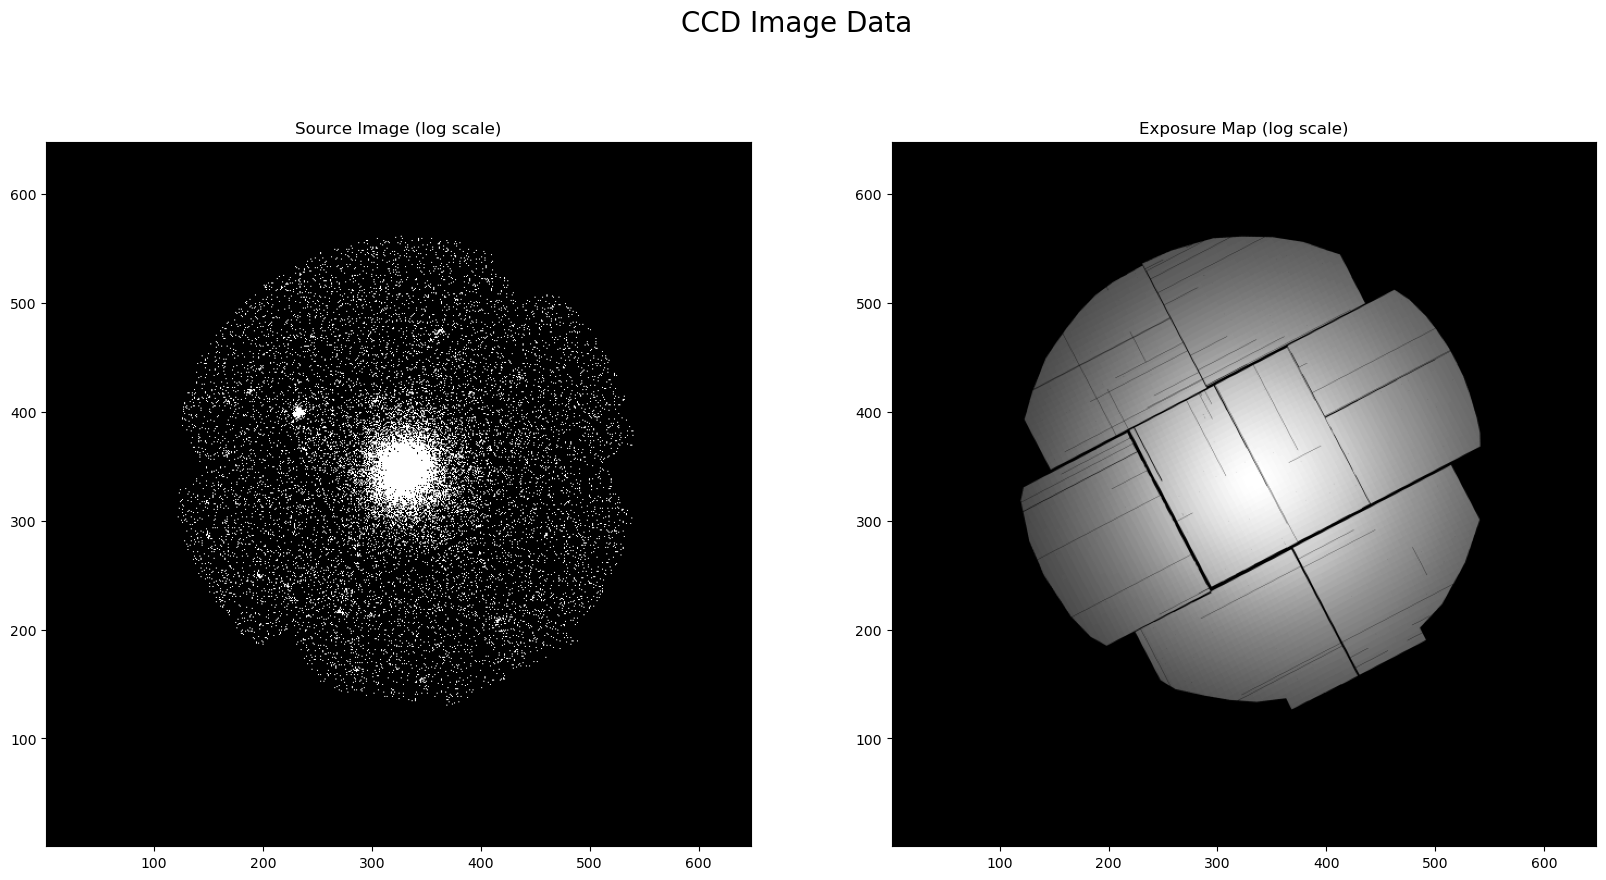

In [3]:
image_path = Path("P0098010101M2U009IMAGE_3000.FTZ")
exposure_map_path = Path("P0098010101M2U009EXPMAP3000.FTZ")

xmm_newton_data = XRayCCD.from_fits(image_path, exposure_map_path)
xmm_newton_data.display()

Note that information from 7 different CCDs in the MOS2 camera have been combined here, and that X and Y in the image arrays correspond to celestial coordinates (right ascension and declination) rather than X and Y on a given detector or in the focal plane.

In the image, we can see:
1. Galaxy cluster Abell 1835 (the big blob in the center).
2. Various other sources (smaller blobs). These are point-like sources - mostly active galactic nuclei (AGN) - that have been smeared out by the telescope's point spread function (PSF).
3. A roughly uniform background, consisting of unresolved AGN, diffuse X-rays from the Galactic halo and local hot bubble,  and events due to particles (solar wind protons and cosmic rays) interacting with the CCD.

The exposure map shows:
1. Clear boundaries between the 7 CCDs that make up the MOS2 camera, and a number of "bad rows/columns" where the exposure has been set to zero.
2. An overall gradient with radius - this is the vignetting function of the telescope.
3. A vaguely circular cut-out shape along the edge. This is applied in preprocessing to eliminate pixels where the effective exposure is essentially zero. All of the CCDs are, in fact, square, and the "corner" regions of the field of view are sometimes used to get a measurement of the portion of the background that is not focussed by the optics (e.g. particle-induced events).

Next, we need to decide on a specific AGN to measure, and decide what size cut-out to make the measurement in, keeping in mind the model assumptions above (especially the uniform background and lack of other AGN within the cut-out). We'll make a standard choice below so that you'll have a known solution to compare to. But, for completeness, here is a list of rough AGN positions in IMAGE coordinates determined some time ago (by eye).

In [4]:
# Pick one of these locations to be the center of the source.
agn_locations = np.array([
    (417, 209),
    (232, 399),
    (188, 418),
    (362, 474),
    (336, 417),
    (381, 359),
    (391, 418),
    (398, 294),
    (271, 216),
    (300, 212),
    (286, 162),
    (345, 153),
    (168, 361),
    (197, 248),
    (277, 234),
    (241, 212),
    (251, 379),
    (310, 413),
    (460, 287),
    (442, 353),
    (288, 268),
    (148, 317),
    (151, 286),
    (223, 239),
    (490, 406),
    (481, 318)
])

Let's take a look at the first coordinate! Make a stamp with width of 50 pixels surrounding that point

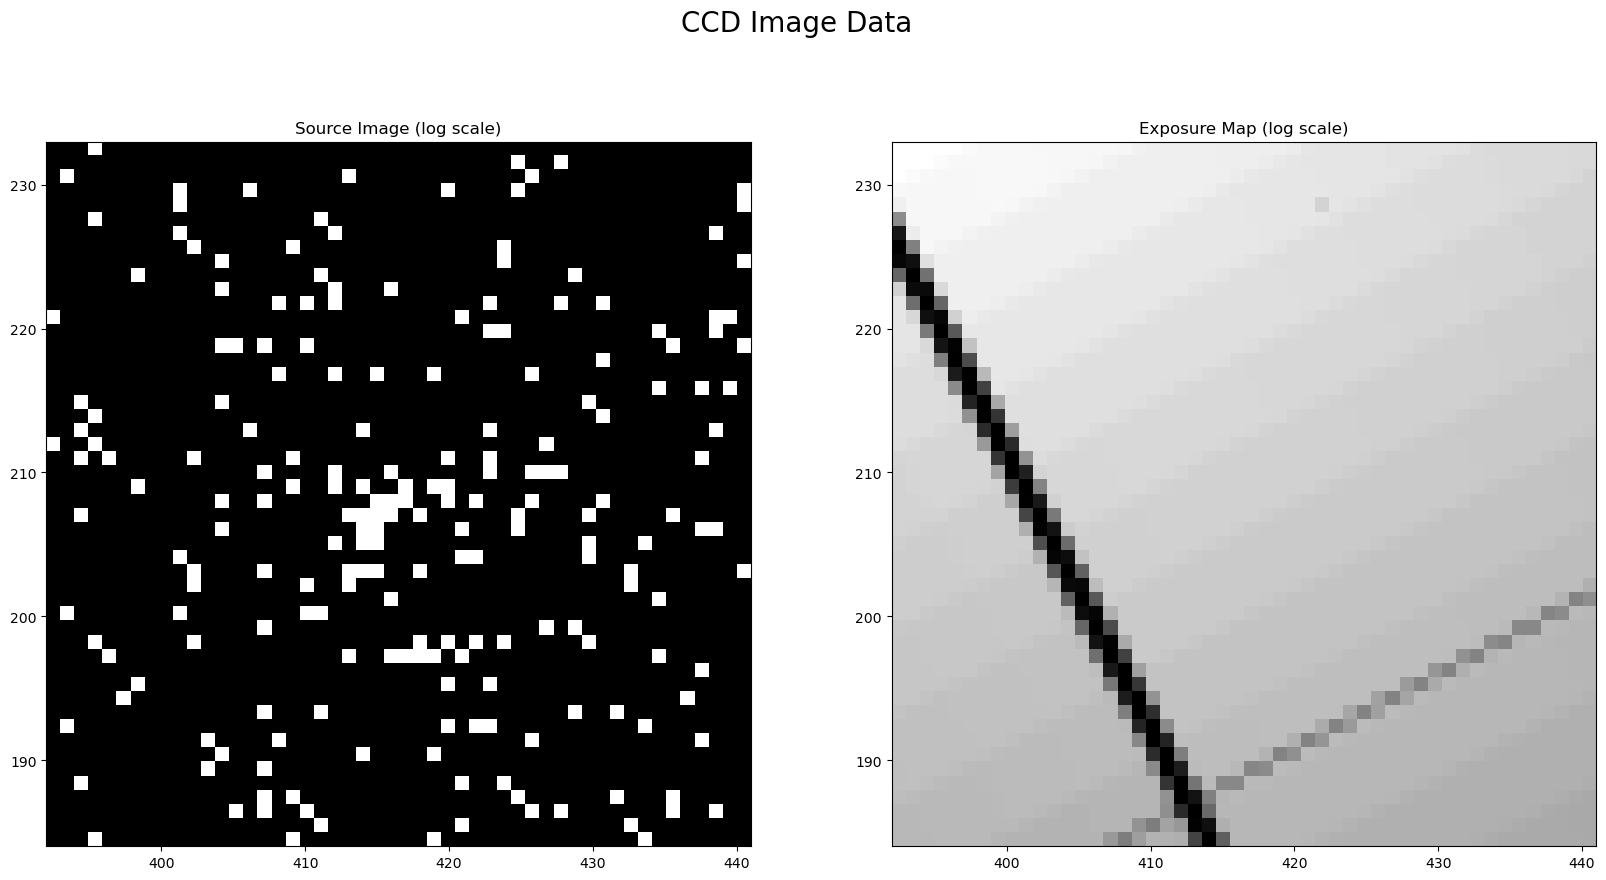

In [5]:
stamp_data = xmm_newton_data.make_postage_stamp(width=50, x0=agn_locations[0][0], y0=agn_locations[0][1])
stamp_data.display()

## Defining a model

Now that you know your way around the image data itself, we're going to fit a model to a cut-out of the data. To keep things simple, we will ignore the galaxy cluster and just fit the brightness of one of the AGN in the field, after asserting that we know both its position and the telescope PSF (this is called "forced photometry").

In generative terms, we will define a 2-dimensional model for source brightness on the sky, apply the PSF to smear it out as the telescope optics would, and apply the exposure map to compute an expected, average number of counts in each pixel given our observation's length. This can then be compared with the measured counts using the sampling distribution which, for counts of rare events, is Poisson. More concretely,

* The physical model we're interested in is the source brightness, $S(x,y)$.
* Assuming the PSF doesn't vary with position within our cut-out, it's action is a simple convolution.
* Multiplication by the exposure map, $E(x,y)$, then takes care of the overall observation length and the position-dependent vignetting.

Even more compactly, we could write the model expectation number of counts per pixel as

$\mu(x,y) = E(x,y) \times \left[\mathrm{PSF}\otimes S(x,y)\right]$,

and the data as

$N(x,y) \sim \mathrm{Poisson}\left[\mu(x,y)\right]$.

Remembering that the exposure map had units of seconds, $S$ as used above must have units of counts per second per pixel (the units of "pixel on the sky" are solid angle). In real life we might want to eventually measure the AGN flux in real units (e.g. ergs/s/cm$^2$), which would require an assumption about the spectrum of the source (or an analysis that didn't throw out the spectral information!). We'll stick to inferring things in terms of counts.

A few more things are necessary to fully specify our model. We'll take the exposure map to be known and fixed, which leaves $S(x,y)$ and the PSF.

An AGN is point-like as far as this telescope is concerned, so we can write

$S_\mathrm{agn}(x,y) = F_0\,\delta(x-x_0)\,\delta(y-y_0)$.

For simplicity, let's assume there is a constant background in whatever region in the image we decide to analyze:

$S_\mathrm{bg}(x,y) = b$.

In the context of measuring the AGN flux, "background" includes the cluster emmission, so we'll want to select an AGN in a part of the field of view where the cluster emission is subdominant to the more uniform background.

Finally, we'll assume a symmetric, Gaussian PSF, with a standard deviation of $\sigma=5''=1.25$ pixels. This is not entirely accurate, but it would take an extremely bright source, or a statistical analysis of many fainter sources, for us to see the actual PSF pattern, which is quite complicated in detail.

We thus have only 2 model parameters to fit, $F_0$ and $b$. Since AGN fluxes span many orders of magnitude, but the quiescent background count rate does not, let's use wide uniform priors on $\ln(F_0)$ and $b$ and see what we can do.

We will use the `ModelParameters` dataclass below to manage the relevant parameters throughout the sampling process. It contains functionality to compute the expected number of counts per pixel $\mu (x, y)$, as well as, the ability to quickly propose new parameters that our sampler will decide to accept or reject.

In order to set this up properly. 

> Create two Gaussian proposal distributions for $\ln F_{0}$ and $b$ using `st.norm` from scipy. Let's sample the proposal for $\ln F_{0}$ from $\mathcal{N}(0,0.1)$ (i.e., a Gaussian with a mean of $0$ and standard deviation of $0.1$), and the proposal for $b$ from $\mathcal{N}(0, 5 \times 10^-7)$ (i.e., a Gaussian with a mean of $0$ and standard deviation of $5 \times 10^7$). 

In [6]:
@dataclass
class ModelParameters: 
    x0: float
    y0: float 
    lnF0: float    # log of the flux at the center of the source
    b: float       # background brightness
    sigma: float
    
    def proposal(self) -> dict[str, float]:
        ''' Fill in the values of the proposal distributions '''
        return {
            "x0": self.x0,
            "y0": self.y0,
            "lnF0": self.lnF0 + st.norm(0, 0.1).rvs(), 
            "b": self.b + st.norm(0, 5E-7).rvs(),
            "sigma": self.sigma
        }
    
    def update_from_proposal(self, params: dict[str, float]) -> None:
        return self.__init__(**params)

    # Model Expectation Number of Counts per Pixel
    def counts_per_pixel(self, data: XRayCCD) -> np.ndarray:
        # Convert self.x0 and self.y0 to integers by subtracting 
        # the coordinate offsets and rounding to the nearest integer
        i = int(round(self.x0 - data.coordinate_offsets[0]))
        j = int(round(self.y0 - data.coordinate_offsets[1]))

        # Ensure i and j are within the bounds of the image
        i = max(0, min(i, data.image.shape[0] - 1))
        j = max(0, min(j, data.image.shape[1] - 1))
        
        # Gaussian PSF for AGN Source 
        pixel_distances = data.pixel_distances_map(i, j, display=False)
        source_agn, source_background = self.lnF0, self.b
        agn_log_z_score = source_agn - (pixel_distances/self.sigma)**2/2
        agnPSF = np.exp(agn_log_z_score)/(2.0 * np.pi * self.sigma**2)
        sourcePSF = agnPSF + source_background

        # Return the expected number of counts per pixel
        return sourcePSF * data.exposure_map

> Based on the information provided above, initialize a set of model parameters 
> using the first AGN location, a $\sigma$ of 1.25 pixels, $\ln F_{0} = -5$, and $b=10^{-6}$

In [7]:
''' Set up the model parameters needed for the MCMC sampler. '''
parameters = ModelParameters(
    x0=agn_locations[0][0], 
    y0=agn_locations[0][1], 
    lnF0=-5, 
    b=1e-6, 
    sigma=1.25
)

It's time to write functions to evaluate the prior, sampling and posterior distributions. Even though we're only fitting for $\ln(F_0)$ and $b$ for the moment, let's write those functions more generally, so that they also depend explicitly on the AGN position, $(x_0,y_0)$, and the PSF width, $\sigma$.

Normally, we try to evaluate the _log_ of these distributions. This is because floating-point underflows can be an issue, especially when the sampling distribution is a product with many terms. Another benefit is that we don't have to worry about normalizing coefficients that don't depend on model parameters - if we need some distribution to be normalized later, we can always normalize it explicitly by dividing it by its numerical integral.

> 1. Complete the `likelihood` function by computing $\mu (x, y)$ and using it calculate $N(x, y)$ by taking that parameter and the image data to get a log likelhood using `logpmf` method from the `st.poisson` distribution.
> 2. Setup your Metropolis-Hastings algorithm by completing the `sample` function. There are some steps below that need to be completed in order to help you out

In [8]:
def prior(data: XRayCCD, params: ModelParameters, log: bool=True) -> float:
    return 0.0 if log else 1.0

def likelihood(data: XRayCCD, params: ModelParameters, log: bool=True) -> float:
    ''' Save the expected number of counts per pixel in a variable called mu_xy.'''
    mu_xy: np.ndarray = params.counts_per_pixel(data)

    ''' Compute the log likelihood of the image data given the model parameters. '''
    log_likelihood = st.poisson.logpmf(data.image, mu_xy)

    return log_likelihood.sum() if log else np.exp(log_likelihood.sum())

def posterior(data: XRayCCD, params: ModelParameters, log: bool=True) -> float:
    return (
        prior(data, params, log=log) + likelihood(data, params, log=log)
        if log else
        prior(data, params, log=log) * likelihood(data, params, log=log)
    )

def sample(data: XRayCCD, params: ModelParameters, num_samples: int) -> List[ModelParameters]:
    ''' Set up the Metropolis-Hastings Sampling Algorithm.'''
    samples = [params]
    for _ in tqdm(range(num_samples), desc="Sampling"):
        proposal: dict[str, float] = params.proposal()
        proposal_params = ModelParameters(**proposal)

        ''' Complete the rest of the Metropolis-Hastings algorithm.'''
        acceptance_ratio = np.exp(posterior(data, proposal_params, log = True) - posterior(data, params, log = True))

        # Use the acceptance ratio to decide whether to accept or reject the proposal.
        if np.random.random() <= acceptance_ratio:
            # params.update_from_proposal(proposal) # this doesn't work for some reason
            params = proposal_params
        samples.append(params)
    return samples

In [9]:
def plot_corner(samples: List[ModelParameters]):
    # Convert list of ModelParameters to a 2D array with shape (num_samples, num_parameters)
    data = np.array([[sample.lnF0, sample.b] for sample in samples])

    # Specify labels and truths
    labels = [r'$\ln F_0$', r'$b$']
    truths = [np.median(data[:, i]) for i in range(data.shape[1])]

    print(truths)

    # Make the corner plot
    fig = corner.corner(data, labels=labels, truths=truths)

def plot_chains(samples: List[ModelParameters]) -> None:
    # Extract the parameters from the samples
    lnF0_samples = [sample.lnF0 for sample in samples]
    b_samples = [sample.b for sample in samples]

    # Plot the chains for each parameter
    plt.figure(figsize=(15, 5))
    plt.subplot(211)
    plt.plot(lnF0_samples)
    plt.ylabel(r'$\ln F_0$', fontsize=16)
    plt.ylim(min(lnF0_samples), max(lnF0_samples)) # remove later
    plt.subplot(212)
    plt.plot(b_samples)
    plt.ylabel(r'$b$', fontsize=16)
    plt.ylim(min(b_samples), max(b_samples)) # remove later
    plt.xlabel('Iteration', fontsize=16)
    plt.tight_layout()
    plt.show()

    


In [112]:
# Test your sampler on 10,000 samples until you get it working
# Then try 100,000 samples to get a good estimate of the posterior
samples = sample(stamp_data, parameters, int(1e5))

Sampling:   0%|          | 0/100000 [00:00<?, ?it/s]

Let's see our results!

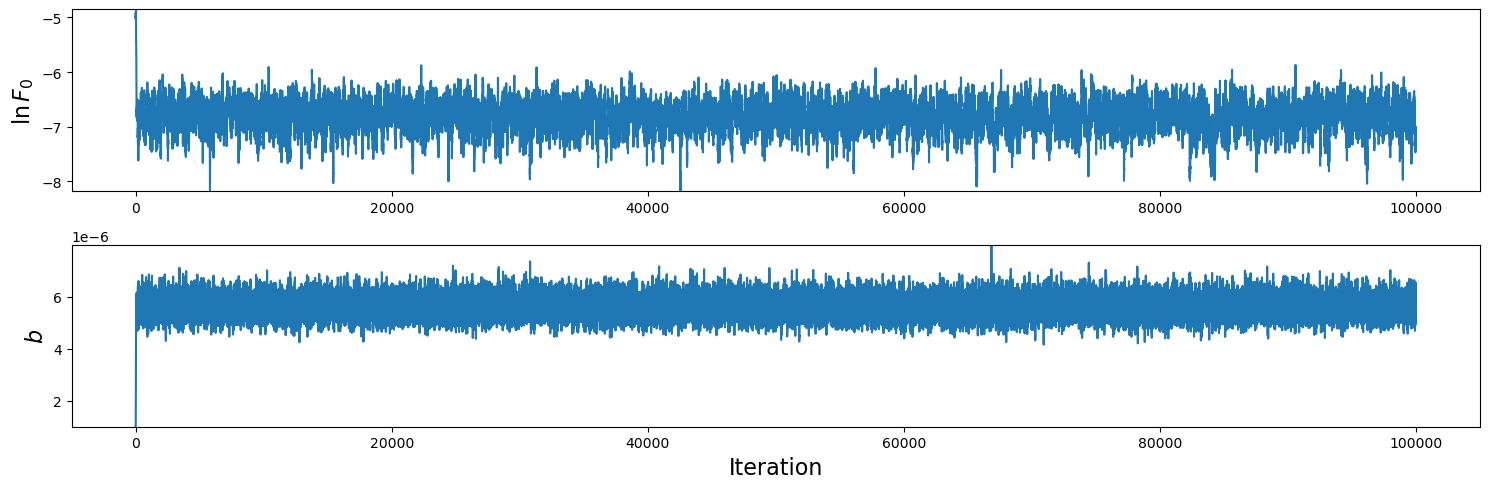

In [113]:
plot_chains(samples)

[-6.791575362549603, 5.613968695218437e-06]


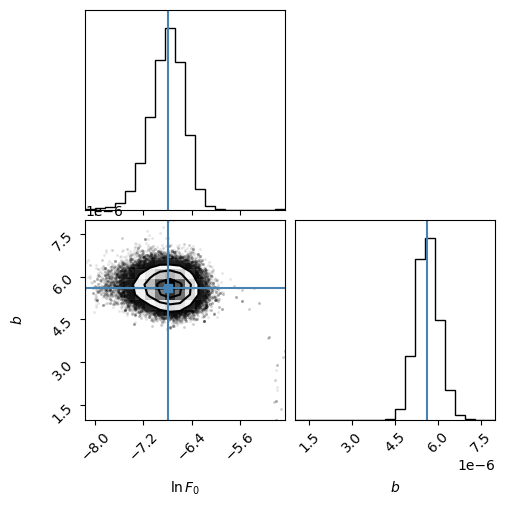

In [114]:
plot_corner(samples)

Run the block below to see how your values compare to the values computed from optimization 

In [10]:
from scipy.optimize import minimize

def optimize_lnF0_b(data: XRayCCD, initial_parameters: ModelParameters) -> ModelParameters:
    def negative_log_likelihood(params: List[float]) -> float:
        # Update lnF0 and b of the parameters
        updated_params = copy.deepcopy(initial_parameters)
        updated_params.lnF0 = params[0]
        updated_params.b = params[1]

        # Calculate the expected number of counts per pixel
        mu_xy = updated_params.counts_per_pixel(data)

        # Calculate the negative log likelihood
        return -np.sum(st.poisson.logpmf(data.image, mu=mu_xy))

    # Perform the optimization
    initial_guess = [initial_parameters.lnF0, initial_parameters.b]
    result = minimize(negative_log_likelihood, initial_guess)

    print(result)

    # Return a new ModelParameters object with the optimized lnF0 and b
    return ModelParameters(
        x0=initial_parameters.x0,
        y0=initial_parameters.y0,
        lnF0=result.x[0],
        b=result.x[1],
        sigma=initial_parameters.sigma
    )

optimal_params = optimize_lnF0_b(stamp_data, parameters)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 765.4982331568291
        x: [-6.761e+00  5.584e-06]
      nit: 9
      jac: [-7.553e-04  6.730e+01]
 hess_inv: [[ 7.251e-02 -3.221e-09]
            [-3.221e-09  1.572e-13]]
     nfev: 177
     njev: 55


Once you have your sampler set up, please feel free to try this out on some other points. 

In [11]:
def sample_point(n):
    stamp_data = xmm_newton_data.make_postage_stamp(width=50, x0=agn_locations[n][0], y0=agn_locations[n][1])
    stamp_data.display()
    samples = sample(
        stamp_data, 
        ModelParameters(
            x0=agn_locations[n][0], 
            y0=agn_locations[n][1], 
            lnF0=-5, 
            b=1e-6, 
            sigma=1.25),
        int(1e5)
    )
    plot_chains(samples)
    plot_corner(samples)
    optimal_params = optimize_lnF0_b(stamp_data, parameters)
    return samples

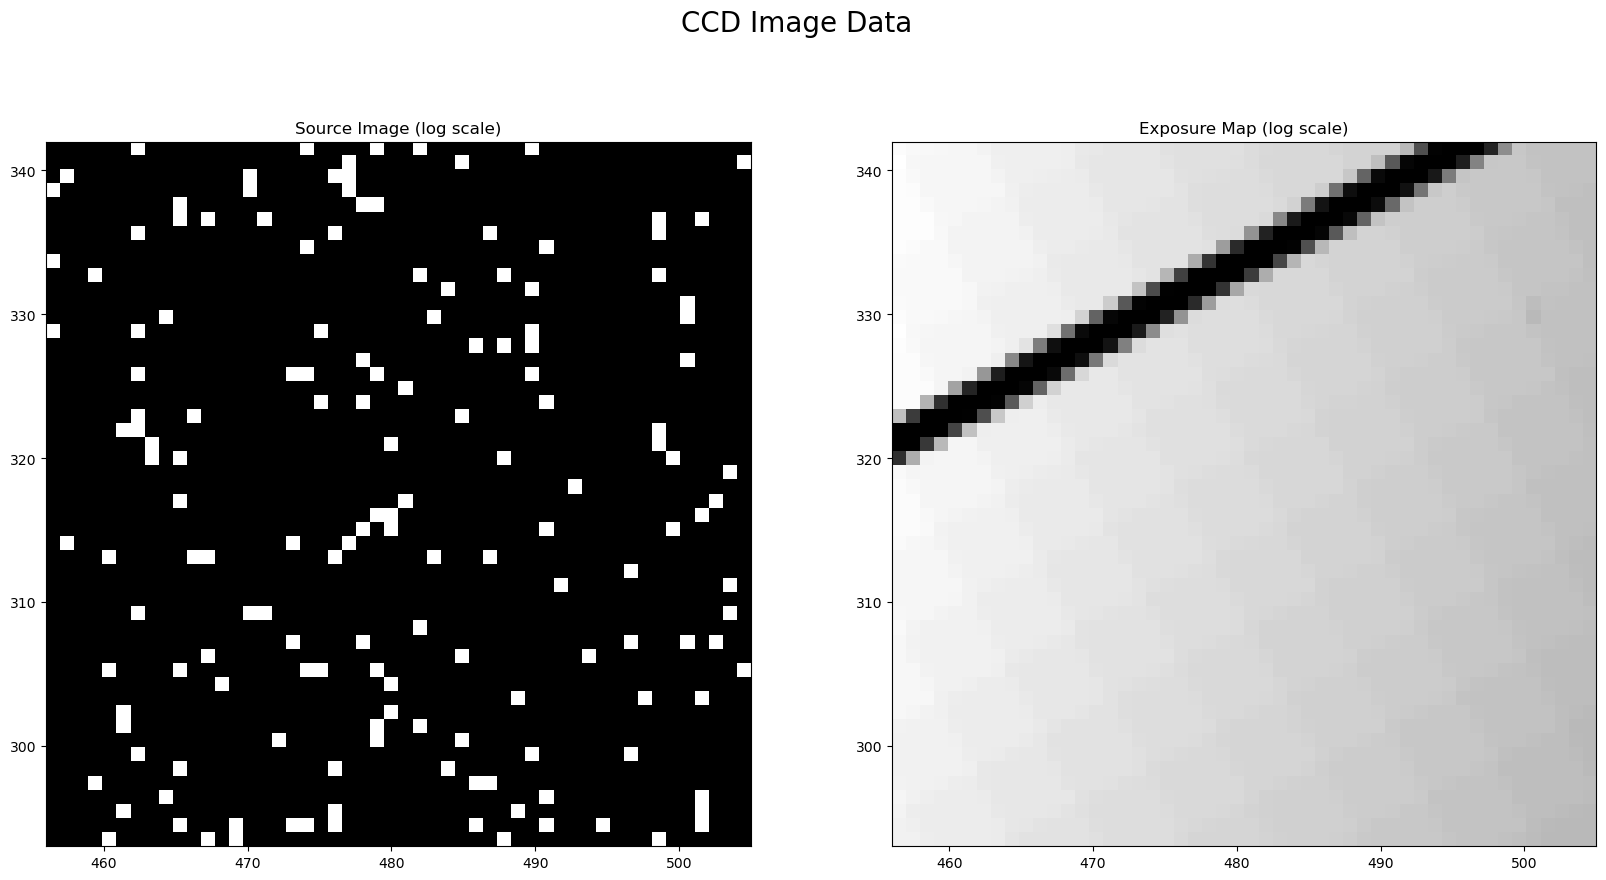

Sampling:   0%|          | 0/100000 [00:00<?, ?it/s]

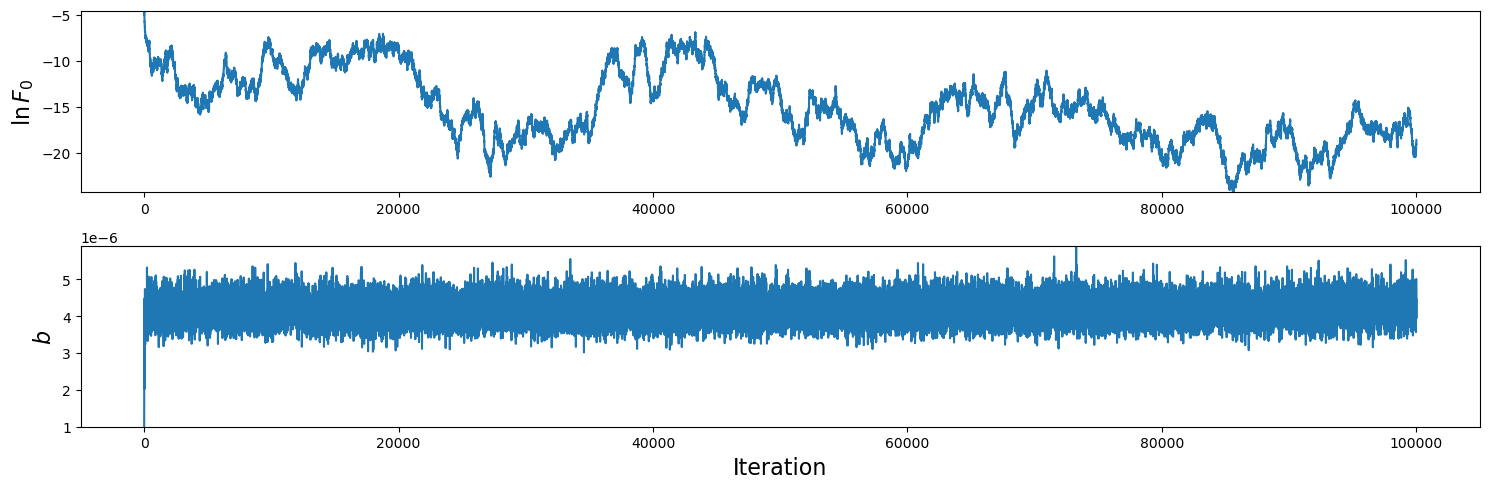

[-15.416419419803173, 4.175875063670724e-06]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 620.413935979749
        x: [-2.155e+01  4.161e-06]
      nit: 31
      jac: [ 7.629e-06  2.947e-02]
 hess_inv: [[ 3.584e-07 -1.081e-10]
            [-1.081e-10  7.611e-14]]
     nfev: 285
     njev: 91


[ModelParameters(x0=481, y0=318, lnF0=-5, b=1e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.870399748239728, b=1.2606368756692906e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.870399748239728, b=1.2606368756692906e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.870399748239728, b=1.2606368756692906e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.870399748239728, b=1.2606368756692906e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.672623963364014, b=1.6496605909481226e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.672623963364014, b=1.6496605909481226e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.661805762272981, b=1.8089312518643469e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.661805762272981, b=1.8089312518643469e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.661805762272981, b=1.8089312518643469e-06, sigma=1.25),
 ModelParameters(x0=481, y0=318, lnF0=-4.6149513062567715, b=3.

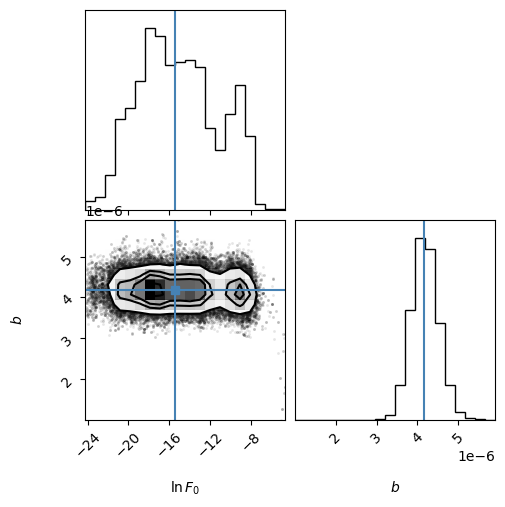

In [12]:
sample_point(-1)